In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from collections import defaultdict

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import random

In [2]:
lemmatizer = WordNetLemmatizer()

def lemma(word):
    word = word.strip()
    
    safe = ["ns"]
    if word in safe:
        return word
    
    noun = lemmatizer.lemmatize(word)
    if noun != word:
        return noun

    adjective = lemmatizer.lemmatize(word, pos="a")
    if adjective != word:
        return adjective

    verb = lemmatizer.lemmatize(word, pos="v")
    if verb != word:
        return verb

    return word

stopwordDict = defaultdict(int)
for sw in stopwords.words("english"):
    stopwordDict[sw] += 1

In [18]:
import pymongo

client = pymongo.MongoClient(host="128.195.180.83",
                             port=27939,
                             username="db_viewer",
                             password="ucidsplab_dbviewer"
                             )
db = client.cloudflare_crawled_data

vocab = {}

corpus, corpus_index, url_list = [], [], []
startPage, endPage = 100, 1354

for i in range(startPage, endPage + 1):
    col_name = "purepage" + str(i)
    collection = db[col_name]
    
    for page in collection.find():
        if not page["DNS_Related"]:
            continue
        
        if "Other Languages" in page["labels"]:
            continue
            
#         date = page["created_date"].split(",")
#         year = date[1][1:5]
#         if year != "2021" and year != "2020":
#             continue
    
        unclassified = True
        if unclassified:
            
            unprocessed, processed = page["original_post"], []
            for word in unprocessed.split(" "):
                lem = lemma(word.strip().lower())
            
                try:
                    _ = int(lem)
                    continue
                except:
                    pass
                
                if lem not in stopwordDict:
                    flag = False
                    for char in lem:
                        if char < "a" or char > "z":
                            flag = True
                    if not flag:
                        processed.append(lem)
                        vocab[lem] = 1
                        
                    
            corpus.append(" ".join(processed))
            corpus_index.append(page["title"])
            url_list.append(page["url"])
             
print(len(corpus))

12145


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
vocabList = vocab.keys()
#cv1 = CountVectorizer(vocabulary=vocabList, analyzer = 'word', ngram_range=(1,2))
cv1 = CountVectorizer(vocabulary=vocabList, analyzer = 'word')
corpus_vocab_count_matrix = cv1.transform(corpus)

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(corpus_vocab_count_matrix)

TfidfTransformer()

In [6]:
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv1.get_feature_names(), columns=['idf-weights'])
df_idf = df_idf.sort_values(by=['idf-weights'])
print(df_idf.head(10))

            idf-weights
cloudflare     1.428240
dns            1.610688
domain         1.782482
use            2.051258
com            2.068365
record         2.211908
get            2.227520
thank          2.256599
work           2.262401
server         2.291928


In [7]:
articles_vocab_count_matrix = cv1.transform(corpus)
tfidf_matrix = tfidf_transformer.transform(articles_vocab_count_matrix)

In [8]:
tfidf_array = np.asarray(tfidf_matrix.todense())
df = pd.DataFrame(tfidf_array[0], index=cv1.get_feature_names(), columns=['tfidf'])
df_descending = df.sort_values(by=['tfidf'], ascending=False)
print(df_descending.head(10))

               tfidf
cornell     0.455808
edu         0.312971
query       0.274808
confluence  0.265888
opt         0.252202
contegix    0.237834
flag        0.218305
answer      0.196958
est         0.149258
dec         0.145079


In [9]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
distance_array = pairwise_distances(tfidf_array, metric='cosine')

In [10]:
distance_array

array([[0.        , 0.9845829 , 0.97935953, ..., 0.93309942, 0.96729512,
        1.        ],
       [0.9845829 , 0.        , 0.95504505, ..., 0.8699352 , 0.92480941,
        0.99177067],
       [0.97935953, 0.95504505, 0.        , ..., 0.94786817, 0.91106483,
        1.        ],
       ...,
       [0.93309942, 0.8699352 , 0.94786817, ..., 0.        , 0.98204333,
        1.        ],
       [0.96729512, 0.92480941, 0.91106483, ..., 0.98204333, 0.        ,
        1.        ],
       [1.        , 0.99177067, 1.        , ..., 1.        , 1.        ,
        0.        ]])

In [11]:
#distance_array = StandardScaler().fit_transform(distance_array)

In [12]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

clustering = DBSCAN(eps=0.6, min_samples=2).fit(distance_array)

In [13]:
for i in range(max(clustering.labels_)):
    print(np.where(clustering.labels_==i)[0])

[  39 9527]
[  120  1219  1776  3116  4977  6466  6701  7503  7580  8313  8721  8864
 10101]
[306 307]
[522 527]
[523 528]
[524 529]
[525 530]
[526 531]
[651 652]
[759 760]
[ 964 9443]
[976 977]
[1044 1045]
[1174 1175]
[1267 1459]
[1448 1449]
[1503 1504]
[1745 1746]
[2025 2027]
[ 2039  9813 11947]
[2178 2183]
[2200 7749]
[2729 5499 6883]
[2765 2766]
[2877 8829]
[3182 3183]
[3275 3276]
[3315 3316]
[3855 3857]
[4135 4136]
[4262 4285]
[4263 4286]
[4264 4287]
[4265 4288]
[4266 4289]
[4267 4290]
[4268 4291]
[4269 4292]
[4270 4293]
[4271 4294]
[ 4362 10717 11642]
[4547 4548]
[4784 4788]
[5378 5379]
[5643 5644]
[5657 5659]
[5658 5660]
[5975 5976]
[5987 5990]
[5988 5991]
[5989 5992]
[6138 6139]
[6166 6167]
[ 6213 11149]
[6372 6598]
[6382 6386]
[6383 6387]
[6384 6388]
[6385 6389]
[6468 6533]
[6859 6860]
[7109 7110]
[7233 9775]
[7372 7374]
[7373 7375]
[7602 7615]
[7603 7616]
[7604 7617]
[7605 7618]
[7606 7619]
[7607 7620]
[7608 7621]
[7609 7622]
[7610 7623]
[7611 7624]
[7612 7625]
[7613 7626]
[7

In [14]:
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True
labels = clustering.labels_
labels

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [15]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

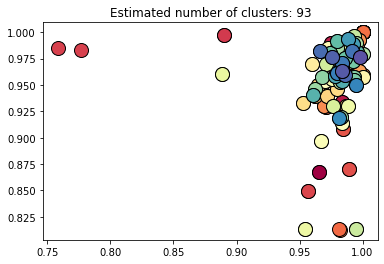

In [16]:
import matplotlib.pyplot as plt
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        continue
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = distance_array[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:,0],
        xy[:,1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = distance_array[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:,0],
        xy[:,1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [17]:
metrics.silhouette_score(distance_array, labels)

-0.25143740388874547